### Energy Usage

Use this [Energy Usage dataset from Kaggle](https://www.kaggle.com/sohommajumder21/appliances-energy-prediction-data-set).

1. Perform EDA on this data. How is this different from other data we've seen?
2. Prepare time series for training, tuning and test sets. Use the "Applicances" column as a target.
3. Select a useful metric, build a simple baseline model, and evaluate it. Explain your metric and model choice.
4. Build a model to predict the target using any model you want, using contemporaneous predictors
   and lags of the "Appliances" column. Evaluate it.
5. Use feature engineering to improve the quality of your model.


---

### **The Data**

The data set is at 10 min for about 4.5 months. The house temperature and humidity conditions were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for 10 minutes periods. The energy data was logged every 10 minutes with m-bus energy meters. Weather from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis (rp5.ru), and merged together with the experimental data sets using the date and time column. Two random variables have been included in the data set for testing the regression models and to filter out non predictive attributes (parameters).

In [92]:
import warnings

# np and pandas
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

from plotnine import ggplot, geom_line, aes, ggtitle, xlab, ylab, theme, geom_density

from sktime.forecasting.arima import ARIMA
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tsdata.raw import available_data, load_data
from sktime.utils.plotting import plot_series
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.series.difference import Differencer
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.var import VAR
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.compose import EnsembleForecaster
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

# set style of plots
plt.style.use('Solarize_Light2')

from tsdata.raw import  load_data
from sktime.utils.plotting import plot_series

Importing plotly failed. Interactive plots will not work.


In [110]:
energy_df = (pd
 .read_csv("../../../data/energy.csv")
#  .assign(date=lambda df: pd.to_datetime(df.date))
 .assign(date=lambda df: pd.date_range(min(df.date), max(df.date), freq='10Min'))
 .set_index('date')
 .assign(
     hour=lambda df: df.index.hour,
     day=lambda df: df.index.day,
     weekday=lambda df: df.index.weekday
 )
)

energy_df.head(4)

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,hour,day,weekday
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,17,11,0
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,17,11,0
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,17,11,0
2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389,17,11,0


### Attribute Information:

- **date** time year-month-day hour:minute:second
- **Appliances** -  energy use in Wh
- **lights** -  energy use of light fixtures in the house in Wh
- **T1** -  Temperature in kitchen area, in Celsius
- **RH_1** -  Humidity in kitchen area, in %
- **T2** -  Temperature in living room area, in Celsius
- **RH_2** -  Humidity in living room area, in %
- **T3** -  Temperature in laundry room area
- **RH_3** -  Humidity in laundry room area, in %
- **T4** -  Temperature in office room, in Celsius
- **RH_4** -  Humidity in office room, in %
- **T5** -  Temperature in bathroom, in Celsius
- **RH_5** -  Humidity in bathroom, in %
- **T6** -  Temperature outside the building (north side), in Celsius
- **RH_6** -  Humidity outside the building (north side), in %
- **T7** -  Temperature in ironing room , in Celsius
- **RH_7** -  Humidity in ironing room, in %
- **T8** -  Temperature in teenager room 2, in Celsius
- **RH_8** -  Humidity in teenager room 2, in %
- **T9** -  Temperature in parents room, in Celsius
- **RH_9** -  Humidity in parents room, in %
- **To** -  Temperature outside (from Chievres weather station), in Celsius
- **Pressure** - (from Chievres weather station), in mm Hg
- **RH_out** -  Humidity outside (from Chievres weather station), in %
- **Wind** - speed (from Chievres weather station), in m/s
- **Visibility** - (from Chievres weather station), in km
- **Tdewpoint** - (from Chievres weather station), Â°C
- **rv1** -  Random variable 1, nondimensional
- **rv2** -  Random variable 2, nondimensional

#### Dimensionality of the data

In [111]:
print(f"rows are {energy_df.shape[0]}")
print(f"columns are {energy_df.shape[1] - 2}")

rows are 19735
columns are 29


### Is there missing data?

In [87]:
missing_count = energy_df.isna().sum().sum()
print(f"There are {missing_count} missing elements")

There are 0 missing elements


#### Mean and Median Appliances by hour

Text(0, 0.5, 'Energy')

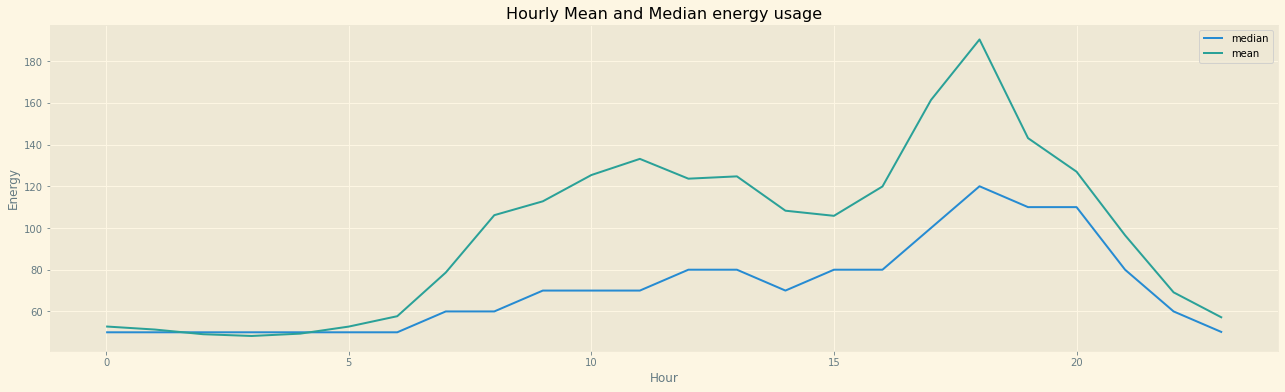

In [89]:
ax = (energy_df
 .groupby('hour')
 .agg(['median', 'mean'])['Appliances']
 .plot(figsize=(22, 6))
)

ax.set_title("Hourly Mean and Median energy usage")
ax.set_xlabel("Hour")
ax.set_ylabel("Energy")

### Correlations between elements

In [82]:
corr = energy_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,hour,day,weekday
Appliances,1.000000,0.197278,0.055447,0.086031,0.120073,-0.060465,0.085060,0.036292,0.040281,0.016965,0.019760,0.006955,0.117638,-0.083178,0.025801,-0.055642,0.039572,-0.094039,0.010010,-0.051462,0.099155,-0.034885,-0.152282,0.087122,0.000230,0.015353,-0.011145,-0.011145,0.216792,0.002366,0.003060
lights,0.197278,1.000000,-0.023528,0.106968,-0.005622,0.050985,-0.097393,0.131161,-0.008859,0.114936,-0.078745,0.141233,-0.079029,0.153756,-0.135347,0.035069,-0.071458,0.012915,-0.157592,-0.008766,-0.074424,-0.010576,0.068543,0.060281,0.020038,-0.036322,0.000521,0.000521,0.255346,-0.041895,-0.099828
T1,0.055447,-0.023528,1.000000,0.164006,0.836834,-0.002509,0.892402,-0.028550,0.877001,0.097861,0.885247,-0.014782,0.654769,-0.615045,0.838705,0.135182,0.825413,-0.006441,0.844777,0.071756,0.682846,-0.150574,-0.345481,-0.087654,-0.076210,0.571309,-0.006203,-0.006203,0.178858,-0.127088,0.001381
RH_1,0.086031,0.106968,0.164006,1.000000,0.269839,0.797535,0.253230,0.844677,0.106180,0.880359,0.205797,0.303258,0.316141,0.245126,0.021397,0.801122,-0.030053,0.736196,0.115263,0.764001,0.340767,-0.293957,0.274126,0.204932,-0.021057,0.639106,-0.000699,-0.000699,0.018594,-0.041397,-0.053782
T2,0.120073,-0.005622,0.836834,0.269839,1.000000,-0.165610,0.735245,0.121497,0.762066,0.231563,0.720550,0.029595,0.801186,-0.580372,0.663660,0.229212,0.578191,0.068534,0.675535,0.157346,0.792255,-0.133028,-0.505291,0.052495,-0.069721,0.582602,-0.011087,-0.011087,0.254784,-0.156913,0.000602
RH_2,-0.060465,0.050985,-0.002509,0.797535,-0.165610,1.000000,0.137319,0.678326,-0.047304,0.721435,0.110409,0.250271,-0.009670,0.389933,-0.051422,0.690584,-0.041023,0.679777,0.054544,0.676467,0.033674,-0.255646,0.584911,0.069190,-0.005368,0.499152,0.006275,0.006275,-0.183322,0.037117,-0.044249
T3,0.085060,-0.097393,0.892402,0.253230,0.735245,0.137319,1.000000,-0.011234,0.852778,0.122737,0.888169,-0.066355,0.686882,-0.647672,0.847374,0.172624,0.795283,0.044427,0.901324,0.134602,0.699417,-0.189974,-0.281718,-0.100776,-0.102310,0.645886,-0.005194,-0.005194,0.037624,-0.077190,-0.017514
RH_3,0.036292,0.131161,-0.028550,0.844677,0.121497,0.678326,-0.011234,1.000000,-0.140457,0.898978,-0.050062,0.375422,0.076833,0.514912,-0.250090,0.832685,-0.283228,0.828822,-0.195270,0.833538,0.118207,-0.233274,0.356192,0.263188,0.017041,0.414387,-0.000477,-0.000477,-0.052392,-0.048427,-0.035182
T4,0.040281,-0.008859,0.877001,0.106180,0.762066,-0.047304,0.852778,-0.140457,1.000000,-0.048650,0.871813,-0.076489,0.652350,-0.703149,0.877763,0.043527,0.796256,-0.095192,0.889439,-0.025549,0.663478,-0.075292,-0.388602,-0.185747,-0.104768,0.519471,-0.001815,-0.001815,0.088407,-0.121867,-0.091006
RH_4,0.016965,0.114936,0.097861,0.880359,0.231563,0.721435,0.122737,0.898978,-0.048650,1.000000,0.091812,0.352591,0.259047,0.392178,-0.131204,0.894301,-0.167066,0.847259,-0.044518,0.856591,0.293289,-0.250748,0.336813,0.300192,0.002636,0.616509,-0.001787,-0.001787,-0.019068,-0.005404,-0.005749


### Things to notice

- Constant after midnight and before dawn with slow usage
- Spike in the morning
- Spikes after 18:00
- The data is with much higher granularity than other time series we have used in the course so far


### Procedure

- Split data to train, test, validation
- Extract features
- Fit a random forest model
-  Evaluate model


### Splitting the data to train, validaiton and test sets

In [112]:
X = energy_df.drop('Appliances', axis=1)
y = energy_df['Appliances']

VALIDATION_SIZE = 6 * 10 * 24 # 10 days for validation
VALIDATION_STEP_SIZE = 6 * 1 * 24 # 1 day
fh=[1]
step_length=90

y_train, y_test, X_train, X_pred = temporal_train_test_split(y, X, test_size=0.3)
cv = SlidingWindowSplitter(window_length=VALIDATION_SIZE, fh=fh, step_length=VALIDATION_STEP_SIZE)

In [131]:
# [y_train[i[1]] for i in cv.split(y_train)]


from linearmodels import PooledOLS
mod = PooledOLS(y_train, X_train[['RH_out', 'T2']])
res = mod.fit(cov_type='clustered', cluster_entity=True)


[2016-01-21 17:00:00    50
 Name: Appliances, dtype: int64,
 2016-01-22 17:00:00    40
 Name: Appliances, dtype: int64,
 2016-01-23 17:00:00    120
 Name: Appliances, dtype: int64,
 2016-01-24 17:00:00    60
 Name: Appliances, dtype: int64,
 2016-01-25 17:00:00    30
 Name: Appliances, dtype: int64,
 2016-01-26 17:00:00    20
 Name: Appliances, dtype: int64,
 2016-01-27 17:00:00    40
 Name: Appliances, dtype: int64,
 2016-01-28 17:00:00    40
 Name: Appliances, dtype: int64,
 2016-01-29 17:00:00    70
 Name: Appliances, dtype: int64,
 2016-01-30 17:00:00    670
 Name: Appliances, dtype: int64,
 2016-01-31 17:00:00    150
 Name: Appliances, dtype: int64,
 2016-02-01 17:00:00    310
 Name: Appliances, dtype: int64,
 2016-02-02 17:00:00    40
 Name: Appliances, dtype: int64,
 2016-02-03 17:00:00    270
 Name: Appliances, dtype: int64,
 2016-02-04 17:00:00    120
 Name: Appliances, dtype: int64,
 2016-02-05 17:00:00    60
 Name: Appliances, dtype: int64,
 2016-02-06 17:00:00    240
 Name: